# Real/Fake Job Posting 

## 1. Library Imports

In [1]:
# data analysis imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# preprocessing imports
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt_tab')
nltk.download('wordnet')

#class imbalance imports
from imblearn.over_sampling import SMOTE

# read the fake job postings dataset
df = pd.read_csv('fake_job_postings.csv')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\kceys\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kceys\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2. Data Exploration

In [2]:
# returns the first 5 rows
df.head()

# describes the numerical features of our dataset
df.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


## 3. Handling missing values

In [3]:
#Finding the total number of missing values for each feature
df.isna().sum()

columns = ['job_id', 'salary_range']
for col in columns:
    del df[col]

# Fill the 'NaN' fields in our dataset to avoid errors when dealing with TF-IDF or our models
df.fillna('unknown', inplace=True)

## 4. Handling Duplicates

In [4]:
# check for duplicates
# no duplicates, so no need to handle them
df.duplicated().sum()

np.int64(288)

## 5. Identifying Class Imbalance

Text(0.5, 0, 'Fradulent (0 = No, 1 = Yes)')

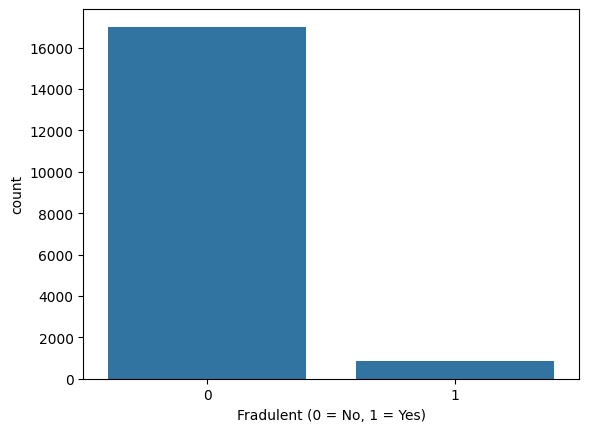

In [5]:
# plot bar chat for rows that are fraudulent
# dataset is imbalanced, will fix soon
sns.countplot(x='fraudulent', data=df)
df['fraudulent'].value_counts()
x_label = "Fradulent (0 = No, 1 = Yes)"
plt.xlabel(x_label)


## 6. Cleaning Text

In [6]:
# generate stop words to clean our text
stop_words = set(stopwords.words('english'))

# add the punctuation list to the set of stop words
punctuation = list(string.punctuation)
stop_words.update(punctuation)

# initialize our lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    '''
    Uses stopwords and lemmatizing to clean the text
     
    Parameters
    ----------
    text: the combined text of all our features
    '''

    # tokenize the text
    tokens = word_tokenize(text.lower())
    # Remove stop words and non-alphabetic tokens and lemmantize
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and token not in stop_words]

    return ' '.join(tokens)


#List of feature columns to clean
feature_list = [ 'title', 'location', 'department', 'company_profile', 'description', 'requirements', 'benefits']

for column in feature_list:
    df[column] = df[column].apply(preprocess_text)

df['text_processed'] = df['title'] + ' ' + df['location'] + ' ' + df['department'] + ' ' + df['company_profile'] + ' ' + df['description'] + ' ' + df['requirements'] + ' ' + df['benefits']

df.drop(columns = ['title', 'location', 'department', 'company_profile', 'description', 'requirements', 'benefits'])


,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,text_processed
0,0,1,0,Other,Internship,unknown,unknown,Marketing,0,marketing intern u ny new york marketing creat...
1,0,1,0,Full-time,Not Applicable,unknown,Marketing and Advertising,Customer Service,0,customer service cloud video production nz auc...
2,0,1,0,unknown,unknown,unknown,unknown,unknown,0,commissioning machinery assistant cma u ia wev...
3,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,account executive washington dc u dc washingto...
4,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,bill review manager u fl fort worth unknown sp...
...,...,...,...,...,...,...,...,...,...,...
17875,0,1,1,Full-time,Mid-Senior level,unknown,Computer Software,Sales,0,account director distribution ca toronto sale ...
17876,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0,payroll accountant u pa philadelphia accountin...
17877,0,0,0,Full-time,unknown,unknown,unknown,unknown,0,project cost control staff engineer cost contr...
17878,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0,graphic designer ng la lagos unknown unknown n...


## 7. Seperating features by type

In [7]:
textual_columns = 'text_processed'
numerical_columns = ['telecommuting', 'has_company_logo', 'has_questions']
categorical_columns = ['employment_type', 'required_experience', 'required_education', 'industry', 'function']



In [8]:
# Define transformations
text_transformer = TfidfVectorizer(max_features=1000, stop_words='english')
cat_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine everything
preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_transformer, textual_columns),
        ('cat', cat_transformer, categorical_columns),
        ('num', 'passthrough', numerical_columns)
    ]
)

## 8. Train/Test Split

In [9]:
# Split data
X = df[[textual_columns] + categorical_columns + numerical_columns]
y = df['fraudulent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Fit the preprocessor
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

## 9. Handling class imbalance

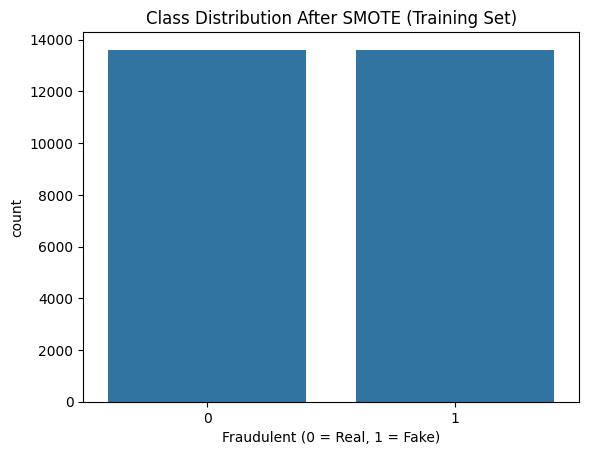

In [10]:
smote = SMOTE(random_state=10, k_neighbors = 3, sampling_strategy = 'minority')
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)

sns.countplot(x=y_train_resampled)
plt.title("Class Distribution After SMOTE (Training Set)")
plt.xlabel("Fraudulent (0 = Real, 1 = Fake)")
plt.show()

In [11]:
# Initialize and train the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred = model.predict(X_test_transformed)

# Evaluate
print(" Accuracy on test set:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))

 Accuracy on test set: 0.9566554809843401

 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98      3403
           1       0.53      0.87      0.66       173

    accuracy                           0.96      3576
   macro avg       0.76      0.92      0.82      3576
weighted avg       0.97      0.96      0.96      3576

